In [261]:
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import layers, Input, models, optimizers
from keras.models import Model, Sequential
from keras.layers import MaxPooling2D, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

### pattern 별로 이미지 선별했기 때문에 따로 불러와서 분류 작업 불필요

## 1. 얼굴있는 사진 제거 및 새로 저장

In [201]:
# 1. 얼굴 인식 코드


face_cascade = cv2.CascadeClassifier(
    './opencv-master/data/haarcascades/haarcascade_frontalface_default.xml')

In [202]:
# 2. 얼굴 분류 함수 


def count_face(x):
    face_cascade = cv2.CascadeClassifier('./opencv-master/data/haarcascades/haarcascade_frontalface_default.xml')
    grayImage = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(grayImage, 1.03, 5)
    return faces.shape[0]

In [203]:
# 3. 폴더 생성 함수

def createfolder(foler_dir):
    try:
        if not os.path.exists(folder_dir):
            os.makedirs(folder_dir)
    except OSError:
        print('Error Creating directory'+folder_dir) 

In [205]:
# 4. noface 하위 폴더 만들기


path = 'C:/python_DA/img/pattern/' # 가져오는 이미지 폴더 path
file_list = os.listdir(path)

for folder_name in file_list:
    path = 'C:/python_DA/img/noface_pattern/' # 새로운 이미지 폴더 path
    folder_dir = path + folder_name
    createfolder(folder_dir)

In [212]:
# 5. noface 사진 다시 저장


path = 'C:/python_DA/img/pattern/'  # 가져오는 이미지 폴더 path
file_list = os.listdir(path)

for _ in range(len(file_list)):
    folder_name = file_list[_]
    new_dir = 'C:/python_DA/img/noface_pattern/' + folder_name # 저장할 path
    jpg_path = path + file_list[_] + '/'
    jpg_file =  os.listdir(jpg_path)
    a = 0
    for i in range(len(jpg_file)):
        image_name = jpg_path + jpg_file[i]
        img = cv2.imread(image_name)

        try:
            count_face(img)
            
        except:
            new_name = new_dir + '/' + jpg_file[i]
            cv2.imwrite(new_name, img)
    
    if _ % 50 == 0:
        print(_)


0


## 2. pattern 분류 모델 생성

### 얼굴 제거 사진(1번 적용 후) 사용해도 되지만 둘 다 해보니 기존 이미지 학습의 정확도가 높음

In [ ]:
# generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     rotation_range = 20,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     rescale = 1. / 255)

In [299]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(150,150, 1))) # RGB:3, gray:1
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
#model.add(Dropout(0.2))
 
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
#model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
#model.add(Dropout(0.2))
 
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(Flatten())
#model.add(Dropout(0.2))
 
model.add(Dense(512, activation='relu'))
model.add(Dense(8, activation='softmax'))                                   # label, calss 갯수
model.summary()
 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 150, 150, 16)      144       
_________________________________________________________________
batch_normalization_36 (Batc (None, 150, 150, 16)      48        
_________________________________________________________________
activation_36 (Activation)   (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 38, 38, 32)        4608      
_________________________________________________________________
batch_normalization_37 (Batc (None, 38, 38, 32)        96        
_________________________________________________________________
activation_37 (Activation)   (None, 38, 38, 32)        0         
__________

## compile 및 데이터 불러오기

In [300]:
# Compiling the CNN

from keras.optimizers import Adam
optimizer = Adam(lr=0.001)

model.compile(optimizer = optimizer, 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])


# 데이터 셋
train_datagen = ImageDataGenerator(rescale=1./255,
#                                    rotation_range=10,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.7,
#                                    zoom_range=[0.9, 2.2],
#                                    horizontal_flip=True,
#                                    vertical_flip=True,
#                                    fill_mode='nearest',
                                   validation_split=0.33)
 
training_set = train_datagen.flow_from_directory('C:/python_DA/img/pattern',
                                                 target_size = (150,150),
                                                 batch_size = 10,
                                                 class_mode = 'categorical',
                                                 subset="training",
                                                 color_mode='grayscale'            # gray_scale로 변경
                                                )
validation_set = train_datagen.flow_from_directory('C:/python_DA/img/pattern',
                                                 target_size = (150,150),
                                                 batch_size = 10,
                                                 class_mode = 'categorical',
                                                 subset="validation",
                                                 color_mode='grayscale'           # gray_scale로 변경
                                                  )
 

Found 4681 images belonging to 8 classes.
Found 2305 images belonging to 8 classes.


## 모델 학습

In [ ]:
# 훈련 세트의 정확도와 테스트 세트의 정확도 사이의 차이는 과대적합(overfitting) 때문
# 과대적합은 머신러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 현상

In [ ]:
# 모델 예측
# predict는 확률을, predict_classes는 label 값을 알려줌

In [301]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


# moniter: 대상 값, mode: min/max, verbose=1 설정시 언제 멈췄는지 출력
# patience: 성능없는 에폭 허용 범위, baseline: 값 설정

#es = EarlyStopping(monitor='val_loss', mode='min')
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [302]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)
mc = ModelCheckpoint('best_model_pattern_417.h5', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
hist = model.fit_generator(training_set,
                         steps_per_epoch = 15, #20
                         epochs = 500,  #1000
                         validation_data = validation_set,
                         validation_steps = 10,
                         callbacks=[es,mc])
 

Epoch 1/500
15/15 [==============================] - 11s 750ms/step - loss: 2.7483 - acc: 0.2333 - val_loss: 2.7246 - val_acc: 0.2300
Epoch 2/500
15/15 [==============================] - 7s 493ms/step - loss: 1.9841 - acc: 0.2800 - val_loss: 1.9519 - val_acc: 0.2400
Epoch 3/500
15/15 [==============================] - 8s 503ms/step - loss: 1.8403 - acc: 0.3000 - val_loss: 2.1553 - val_acc: 0.1900
Epoch 4/500
15/15 [==============================] - 8s 503ms/step - loss: 1.8848 - acc: 0.3467 - val_loss: 2.3208 - val_acc: 0.1500
Epoch 5/500
15/15 [==============================] - 8s 509ms/step - loss: 1.8436 - acc: 0.3600 - val_loss: 1.8837 - val_acc: 0.3500
Epoch 6/500
15/15 [==============================] - 8s 501ms/step - loss: 1.8479 - acc: 0.3200 - val_loss: 2.1954 - val_acc: 0.1800
Epoch 7/500
15/15 [==============================] - 7s 494ms/step - loss: 1.7608 - acc: 0.3200 - val_loss: 1.7689 - val_acc: 0.3800
Epoch 8/500
15/15 [==============================] - 8s 508ms/step -

15/15 [==============================] - 8s 508ms/step - loss: 1.0045 - acc: 0.7000 - val_loss: 1.2893 - val_acc: 0.5700
Epoch 63/500
15/15 [==============================] - 8s 524ms/step - loss: 0.9259 - acc: 0.6400 - val_loss: 1.3905 - val_acc: 0.5400
Epoch 64/500
15/15 [==============================] - 8s 504ms/step - loss: 1.1132 - acc: 0.6067 - val_loss: 1.3708 - val_acc: 0.5400
Epoch 65/500
15/15 [==============================] - 8s 510ms/step - loss: 0.9387 - acc: 0.6667 - val_loss: 1.1638 - val_acc: 0.5300
Epoch 66/500
15/15 [==============================] - 8s 526ms/step - loss: 1.0034 - acc: 0.6067 - val_loss: 1.5072 - val_acc: 0.5200
Epoch 67/500
15/15 [==============================] - 8s 523ms/step - loss: 0.9072 - acc: 0.6800 - val_loss: 1.5746 - val_acc: 0.4600
Epoch 68/500
15/15 [==============================] - 8s 521ms/step - loss: 0.9004 - acc: 0.6800 - val_loss: 1.6749 - val_acc: 0.4900
Epoch 69/500
15/15 [==============================] - 8s 501ms/step - loss:

15/15 [==============================] - 8s 510ms/step - loss: 0.8272 - acc: 0.7600 - val_loss: 1.4862 - val_acc: 0.5600
Epoch 124/500
15/15 [==============================] - 7s 499ms/step - loss: 0.7011 - acc: 0.7267 - val_loss: 1.1126 - val_acc: 0.6600
Epoch 125/500
15/15 [==============================] - 8s 503ms/step - loss: 0.7230 - acc: 0.6933 - val_loss: 1.4749 - val_acc: 0.5800
Epoch 126/500
15/15 [==============================] - 8s 510ms/step - loss: 0.6161 - acc: 0.7800 - val_loss: 1.0816 - val_acc: 0.7100
Epoch 127/500
15/15 [==============================] - 8s 505ms/step - loss: 0.6954 - acc: 0.8133 - val_loss: 0.9500 - val_acc: 0.6900
Epoch 128/500
15/15 [==============================] - 8s 501ms/step - loss: 0.5807 - acc: 0.7867 - val_loss: 1.0750 - val_acc: 0.6700
Epoch 129/500
15/15 [==============================] - 7s 496ms/step - loss: 0.5770 - acc: 0.7867 - val_loss: 1.0228 - val_acc: 0.6700
Epoch 130/500
15/15 [==============================] - 8s 501ms/step 

Epoch 184/500
15/15 [==============================] - 8s 500ms/step - loss: 0.6530 - acc: 0.7800 - val_loss: 1.6914 - val_acc: 0.5300
Epoch 185/500
15/15 [==============================] - 8s 507ms/step - loss: 0.6632 - acc: 0.7933 - val_loss: 1.0520 - val_acc: 0.7000
Epoch 186/500
15/15 [==============================] - 8s 504ms/step - loss: 0.7079 - acc: 0.7267 - val_loss: 1.2350 - val_acc: 0.5800
Epoch 187/500
15/15 [==============================] - 8s 503ms/step - loss: 0.6146 - acc: 0.8200 - val_loss: 0.9812 - val_acc: 0.6500
Epoch 188/500
15/15 [==============================] - 8s 500ms/step - loss: 0.6688 - acc: 0.7600 - val_loss: 1.6563 - val_acc: 0.5500
Epoch 189/500
15/15 [==============================] - 7s 496ms/step - loss: 0.4715 - acc: 0.8000 - val_loss: 1.7816 - val_acc: 0.5200
Epoch 190/500
15/15 [==============================] - 7s 498ms/step - loss: 0.4710 - acc: 0.8467 - val_loss: 1.0995 - val_acc: 0.6500
Epoch 191/500
15/15 [==============================] - 

## 학습 결과 확인: 그래프

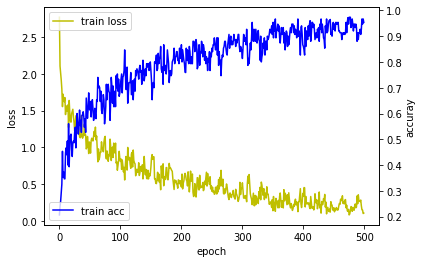

In [294]:
# 학습 과정 정확도, 손실함수 변화 그래프로 보기

import matplotlib.pyplot as plt
 
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
 
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
#loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
##loss_ax.set_ylim([0.0, 0.5])
 
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
#acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
##acc_ax.set_ylim([0.8, 1.0])
 
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')
 
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
 
plt.show()

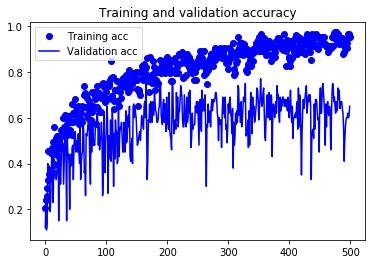

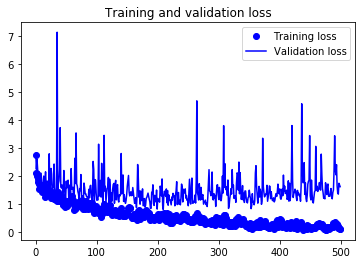

In [293]:
# 다른 방식으로 나타낸 그래프

acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 학습 결과 확인: 정확도 및 예측

In [292]:
# output = classifier.predict_generator(test_set, steps=5)
# print(test_set.class_indices)
# print(output)
 
# 모델 평가하기
print("-- Evaluate --")
 
scores = model.evaluate_generator(
            validation_set,
            steps = 10)
 
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
 
# 모델 예측하기
print("-- Predict --")
 
output = model.predict_generator(
            validation_set,
            steps = 100)
print(validation_set.class_indices)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
 

-- Evaluate --
acc: 65.00%
-- Predict --
{'camo': 0, 'check': 1, 'dot': 2, 'floral': 3, 'graphic': 4, 'leopard': 5, 'none': 6, 'stripe': 7}


## 모델 저장

In [277]:
# 모델 저장


from keras.models import load_model, model_from_json
model.save('./model/pattern_no_lace_정확도.h5')                      # 모델(architecture, weight 동시 저장) 저장 이름


# 모델 아키텍처를 json 형, 식으로 저장                 # 모델 architecture 만 저장 
#json_string = model.to_json()                       # json 파일에서 모델 아키텍처 재구성
#model = model_from_json(json_string) 


# 모델 Weights 저장
# model.save_weights('파일이름')


## 저장 모델 load 및 예측

In [250]:
from keras.models import load_model

model = load_model('./model/model_pattern_final.h5') # 불러올 모델 이름

In [194]:
import json
import pprint

model_json = model.to_json()
pprint.pprint(json.loads(model_json))

{'backend': 'tensorflow',
 'class_name': 'Sequential',
 'config': [{'class_name': 'Conv2D',
             'config': {'activation': 'linear',
                        'activity_regularizer': None,
                        'batch_input_shape': [None, 150, 150, 3],
                        'bias_constraint': None,
                        'bias_initializer': {'class_name': 'Zeros',
                                             'config': {}},
                        'bias_regularizer': None,
                        'data_format': 'channels_last',
                        'dilation_rate': [1, 1],
                        'dtype': 'float32',
                        'filters': 16,
                        'kernel_constraint': None,
                        'kernel_initializer': {'class_name': 'VarianceScaling',
                                               'config': {'distribution': 'uniform',
                                                          'mode': 'fan_avg',
                                

['camo', 'check', 'dot', 'floral', 'graphic', 'lace', 'leopard', 'none', 'stripe']
7
--이 사진의 pattern 값--
none


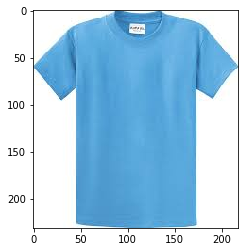

In [233]:
img = Image.open('C:/python_DA/img/001.jpg')  # 불러올 이미지 경로
plt.imshow(img)

img = img.resize((150,150))
data = np.array(img)
data = data.astype('float')
data = data/255
data = data.reshape((1,150,150,3))


#result = np.argmax(data)

var = list(training_set.class_indices.keys())   # y에 해당되는 값
print(var)

result = model.predict_classes(data)[0]
print(result)

print('--이 사진의 pattern 값--')
print(var[result])

